In [148]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf

class Dataset():
    """ Create dataset custom class that contains image data generator from keras preprocessing.
    this class contains labels, batch_size of the dataset, and the core path of the dataset.
    this class can get the sample of image using the get sample function.
    
    """
    def __init__(self,path,image_size,train_size):
        self.path=path
        self.data=pd.DataFrame([],columns=['Image_path','Classes'])
        self.image_size=image_size
        self.train_size=train_size
        self.label={}
        self.loadImage()
    def loadImage(self):
        image_data=[]
        for dir_path, _, file_names in os.walk(self.path):
                for file_name in file_names:
                    # Process only image files
                    if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_path = os.path.join(dir_path, file_name)
                        classes=dir_path.split('/')[-1]
                        image_data.append({'Image_Path': image_path, 'Class':classes})
        self.data=pd.DataFrame(image_data)

    def preprocessedImage(self,image_path):
            image = cv.imread(image_path)
            # Convert the image to grayscale
            gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            equalized= cv.equalizeHist(gray_image)
            blurred = cv.GaussianBlur(equalized, (5, 5), 0)
            # Resize the image to the target size
            resized_image = cv.resize(blurred, self.image_size)
            normalized = resized_image.astype('float32') / 255.0
            return normalized
    
    def getSample(self,grayscale=False):
        random_idx=random.randint(0,len(self.data))
        sample=self.data.iloc[random_idx]
        img_path,label=sample['Image_Path'],sample['Class']
        img=cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY if grayscale else cv.COLOR_BGR2RGB)
        plt.title(f' Sample Image Of : {label}')
        plt.axis('off')
        plt.imshow(img,cmap='gray' if grayscale else 'viridis')
        plt.show(block=True)
        print(img.shape)
        return img
    
    def generateDataset(self):
        self.label_to_idx= {label: index for index, label in enumerate(self.data['Class'].unique())}
        self.idx_to_label= {index: label for index, label in enumerate(self.data['Class'].unique())}
        numerical_labels = [self.label_to_idx[label] for label in self.data['Class']]
        labels = tf.keras.utils.to_categorical(numerical_labels)
        gray=self.data['Image_Path'].apply(self.preprocessedImage)
        gray=np.array(gray.tolist())
        x_train,x_test,y_train,y_test=train_test_split(gray,labels,train_size=self.train_size,random_state=42)
        return (x_train,x_test,y_train,y_test)

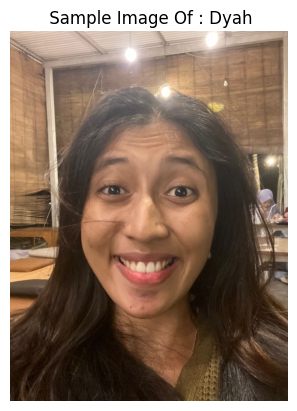

(1600, 1200, 3)


In [149]:
dataset=Dataset('../Data/',image_size=(80,80),train_size=0.8)
img=dataset.getSample()

In [150]:
x_train,x_test,y_train,y_test=dataset.generateDataset()
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((971, 80, 80), (243, 80, 80), (971, 3), (243, 3))

In [151]:
import tensorflow as tf
#  Check if GPU is available and TensorFlow is using GPU
if tf.test.is_gpu_available():
    print("GPU is available")
    print("TensorFlow is using GPU")
else:
    print("GPU is not available")
    print("TensorFlow is using CPU")
    
# Create a TensorFlow session with GPU options
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

GPU is available
TensorFlow is using GPU


c:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\client\session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


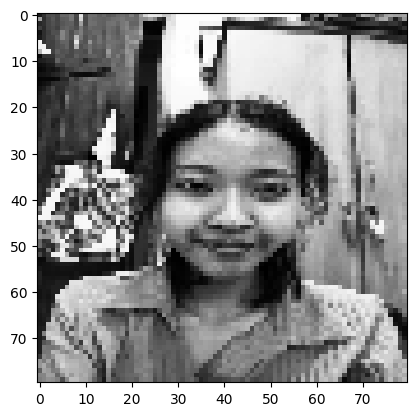

In [152]:
plt.imshow(x_train[11],cmap='gray')

In [163]:
class Model:
    def __init__(self,label:dict) -> None:
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                32, (3, 3), activation='relu', input_shape=(80, 80, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            # num_classes is the number of output classes
            tf.keras.layers.Dense(3, activation='softmax')
        ])
        self.label=label
        self.model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
        self.model.summary()
        self.history=None
        self.score=[]

    def trainModel(self,x_train,y_train,epochs):
        self.history=self.model.fit(x_train,y_train,epochs=epochs)
    
    def evaluateModel(self,x_test,y_test):
        self.score=self.model.evaluate(x_test,y_test)
    
    def preprocessImage(self,img):
        gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        equalized= cv.equalizeHist(gray_image)
        blurred = cv.GaussianBlur(equalized, (5, 5), 0)
        # Resize the image to the target size
        resized_image = cv.resize(blurred, (80,80))
        normalized = resized_image.astype('float32') / 255.0
        return normalized
    
    def predict(self,img:np.array):
    # Convert the image to grayscale
        preprocessed=self.preprocessImage(img)
        normalized=np.expand_dims(preprocessed,axis=0)
        predict=self.model.predict(normalized)
        predict=np.argmax(predict)
        plt.imshow(img)
        plt.title(str(self.label[predict]))
        plt.axis('off')

    def stream(self):
        face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
        # define video capture -> load video dari webcam
        video_capture = cv.VideoCapture(0)
        while True:
            isTrue,frame=video_capture.read()
            preprocessed_frame=self.preprocessImage(frame)
            preprocessed_frame=np.expand_dims(preprocessed_frame, axis=-1)
            frame_expanded=tf.expand_dims(preprocessed_frame,axis=0)
            # make predictions
            predictions = self.model.predict(frame_expanded).squeeze()
            label=np.argmax(predictions)
            faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            for (x, y, w, h) in faces:
                cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv.putText(frame,str(self.label[label]),org=(x, y-10),fontFace=cv.FONT_HERSHEY_SIMPLEX,fontScale=0.9,color=(255,0,0),thickness=2,lineType=cv.LINE_AA)
            cv.imshow('Video', frame)
            cv.imshow('Grayscale', preprocessed_frame)

            # Exit loop if 'q' is pressed
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
                # Destroy window when the real time predictions end
        cv.destroyAllWindows()
        

In [164]:
model=Model(label=dataset.idx_to_label)
model.trainModel(x_train,y_train,epochs=10)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 78, 78, 32)        320       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 39, 39, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 18, 18, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 flatten_16 (Flatten)        (None, 16384)           

In [165]:
model.evaluateModel(x_test,y_test)

8/8 [==============================] - 0s 15ms/step - loss: 0.2436 - accuracy: 0.9630


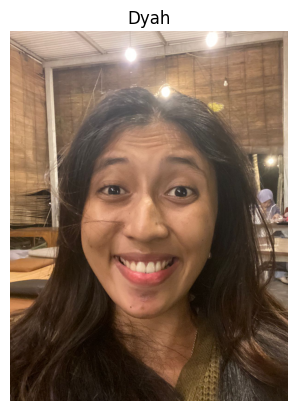

In [166]:
model.predict(img=img)

In [168]:
model.stream()

(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80, 80, 1)
(80,